### Import Libraries

In [1]:
from wrapper_functions_CAR import *
tf.config.run_functions_eagerly(True)
np.random.seed(10)

C:\Users\nickl\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
C:\Users\nickl\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


TensorFlow version: 2.10.0. Expected: 2.7.0
TensorFlow Probability version: 0.18.0. Expected: 0.15.0


### Create the fake data



In [2]:
training2010 = pd.read_csv('../data/merged_wp_census_data2_081122.csv')
county_adj = pd.read_csv('../data/countyadj2.csv', index_col = 0)
#models = ['acs', 'pep', 'worldpop']
models = ['acs', 'pep']

In [3]:
data_NY, adj_NY = subset_data_by_state(training2010, county_adj, 'New York', 'NY')
#phi_true, u_true, data = simulate_data(data_NY, adj_NY, pivot = -1, sim_numbers = True, one_model = False, models = models)

In [4]:
phi_true, u_true, data_pivot = simulate_data(data_NY[:], 
                                                 adj_NY[:], 
                                                 sim_numbers = False,
                                                 scale_down = 1,
                                                 poisson_noise = False,
                                                 pivot = -1, 
                                                 one_model = False, 
                                                 models = models)

fixing tau2 and rho


ValueError: Length of values (1) does not match length of index (62)

# Default Configs

In [ ]:
# MCMC configs.
mcmc_step_size=0.1 # @param
mcmc_sample_size=500 # @param
mcmc_num_steps=10_000 # @param
mcmc_burnin=2_500 # @param
mcmc_nchain=10 # @param
mcmc_seed=0 # @param

DEFAULT_MCMC_CONFIG = dict(step_size=mcmc_step_size, 
                           num_steps=mcmc_sample_size, 
                           burnin=mcmc_burnin, 
                           nchain=mcmc_nchain, 
                           seed=mcmc_seed)

#### Running with HMC

In [ ]:
mcmc_config = DEFAULT_MCMC_CONFIG.copy()
mcmc_config.update(dict(burnin = 2_500, num_steps = 10_000, nchain = 5, 
                        kernel_type = 'hmc', step_adaptor_type = 'simple'))
mcmc_config

In [13]:
res_dict = {}
for pivot_DGP in range(-1, 2):
    print('pivot DGP: ' + str(pivot_DGP))
    
    phi_true, u_true, data_pivot = simulate_data(data_NY[:], 
                                                 adj_NY[:], 
                                                 sim_numbers = False,
                                                 scale_down = 1000,
                                                 poisson_noise = True,
                                                 pivot = pivot_DGP, 
                                                 one_model = False, 
                                                 models = models)
    
    for pivot_fit in range(-1, 2):
        print('pivot fit: ' + str(pivot_fit))
        t0 = time.perf_counter()
        CAR_samples, chain_samples, sampler_stat = run_mcmc_CAR(data = data_pivot[:],
                                                                adjacency = adj_NY[:],
                                                                pivot = pivot_fit,
                                                                models = models,                                                        
                                                                debug_mode = True,
                                                                **mcmc_config)  
        print(time.perf_counter() - t0)
        
        res_dict['pDGP: ' + str(pivot_DGP) + '; pfit: ' + str(pivot_fit)] = [CAR_samples, chain_samples, sampler_stat, phi_true, u_true, data_pivot, pivot_DGP, pivot_fit, models]
        

Saving and loading Python objects with Pickle

In [ ]:
data_pivot

In [ ]:
import pickle

# using local data file because these are too big for github
#local_dir = 'C:/Users/nickl/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
with open(local_dir + 'CAR_samples_NY_n10000_realdata_div1000_2models_May152023.pickle', 'wb') as results_file:
  pickle.dump([res_dict, mcmc_config], results_file)
  #pickle.dump([CAR_samples, CAR_samples0, CAR_samples1, CAR_samples2, CAR_samples], results_file)

### Loading results and analyzing

In [2]:
#local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
local_dir = 'C:/Users/nickl/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
file = local_dir + 'CAR_samples_NY_n10000_realdata_2models_May152023.pickle'
with open(file, "rb") as input_file:
     #CAR_samples, chain_samples, sampler_stat, mcmc_config, phi_true, u_true, data_sub = pickle.load(input_file)
    res_dict, mcmc_config = pickle.load(input_file)

In [4]:
models = ['acs', 'pep']

dict_keys(['pDGP: -1; pfit: -1', 'pDGP: -1; pfit: 0', 'pDGP: -1; pfit: 1', 'pDGP: 0; pfit: -1', 'pDGP: 0; pfit: 0', 'pDGP: 0; pfit: 1', 'pDGP: 1; pfit: -1', 'pDGP: 1; pfit: 0', 'pDGP: 1; pfit: 1'])

In [26]:
data_pivot = res_dict['pDGP: -1; pfit: -1'][5]
tt = res_dict['pDGP: -1; pfit: -1'][4][0].numpy()
tt.shape, data_pivot.shape, type(tt), type(data_pivot)

((62, 2), (62, 8), numpy.ndarray, pandas.core.frame.DataFrame)

In [36]:
nn = ['u_' + m for m in models]
B = pd.DataFrame(tt, columns = nn)
pd.concat([data_pivot.reset_index(drop = True), B], axis = 1)

,GEOID,NAME,acs,census,pep,lon,lat,worldpop,u_acs,u_pep
0,36001,"Albany County, New York",304032,305061,304086,-73.974518,42.603919,3.032997e+05,0.500439,0.499561
1,36003,"Allegany County, New York",49105,49467,48971,-78.033523,42.256043,4.897503e+04,0.646317,0.353683
2,36005,"Bronx County, New York",1365725,1373032,1387298,-73.864945,40.856182,1.381498e+06,0.349783,0.650217
3,36007,"Broome County, New York",200804,200524,200481,-75.817663,42.163367,2.004209e+05,0.565534,0.434466
4,36009,"Cattaraugus County, New York",80776,80833,80218,-78.677160,42.249673,7.977512e+04,0.456967,0.543033
...,...,...,...,...,...,...,...,...,...,...
57,36115,"Washington County, New York",63088,63528,63356,-73.442171,43.321778,6.305826e+04,0.782530,0.217470
58,36117,"Wayne County, New York",93654,92940,93751,-77.035188,43.159389,9.382170e+04,0.554320,0.445680
59,36119,"Westchester County, New York",939406,943601,950601,-73.762510,41.163507,9.534233e+05,0.619106,0.380894
60,36121,"Wyoming County, New York",42367,42123,42126,-78.232321,42.701279,4.132217e+04,0.339609,0.660391


## Getting the rhat and ESS values

In [16]:
res_dict.keys(), stepsize_vec

(dict_keys(['pDGP: -1; pfit: -1', 'pDGP: -1; pfit: 0', 'pDGP: -1; pfit: 1', 'pDGP: 0; pfit: -1', 'pDGP: 0; pfit: 0', 'pDGP: 0; pfit: 1', 'pDGP: 1; pfit: -1', 'pDGP: 1; pfit: 0', 'pDGP: 1; pfit: 1']),
 [1.1682984e-05,
  0.0046667918,
  1.5436617e-05,
  0.00014921912,
  3.2046146e-06,
  1.8835599e-05,
  7.647128e-07,
  2.9182307e-05,
  0.0025182196])

In [18]:
stepsize_vec = list()
for key in res_dict.keys():
    sampler_stat = res_dict[key][2]
    stepsize_vec.append(sampler_stat[0][0].numpy())
    
# make the data frame
df_stepsize = pd.DataFrame(np.reshape(np.array(stepsize_vec), (3,3)), 
                       index = ['no pivot DGP','acs pivot DGP','pep pivot DGP'], 
                       columns = ['no pivot fit','acs pivot fit','pep pivot fit'])
df_stepsize

,no pivot fit,acs pivot fit,pep pivot fit
no pivot DGP,1.168298e-05,0.004667,0.000015
acs pivot DGP,1.492191e-04,0.000003,0.000019
pep pivot DGP,7.647128e-07,0.000029,0.002518


In [11]:
## Get the convergence diagnostics from model fits
rhat_vec = []
for key in res_dict.keys():
    #print(key)
    chain_samples = res_dict[key][1]
    u_samples = phi_to_u(chain_samples, res_dict[key][7])
    ESS = tfp.mcmc.effective_sample_size(u_samples, cross_chain_dims = 1).numpy()
    rhat = tfp.mcmc.potential_scale_reduction(chain_samples, independent_chain_ndims=1).numpy()
    print(np.quantile(ESS, [0.5, 0.025, 0.975]))
    print(np.quantile(rhat, [0.5, 0.025, 0.975]))

[5.00000954 5.0000029  5.00011246]
[ 637076.375        44222.35048828 2346028.75625   ]
[ 7.32836008  5.35947452 14.29406428]
[ 3.57142806  1.59050885 14.59372241]
[5.00004983 5.00001287 5.00016375]
[114453.26953125  37444.62558594 428609.503125  ]
[5.04103756 5.01119919 5.18324046]
[134.42417908  17.00161848 765.81586304]
[5.00002766 5.00000587 5.00022035]
[215944.3515625   27592.26240234 874653.6546875 ]
[5.00005627 5.00001404 5.00066663]
[105245.28515625  16535.31437988 399333.59453125]
[5.         5.         5.00000095]
[4.54075100e+07 2.99653667e+06 1.61172217e+08]
[5.0001893  5.00006272 5.00128139]
[31891.19824219  5702.54732666 90513.62363281]
[ 6.56389284  5.37512708 14.11679049]
[ 4.67269111  1.50161809 13.92534544]


## Plotting the density of ensemble weights

In [ ]:
import seaborn as sns
#plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.figsize'] = [15, 3]
labels = models[:]
labels.insert(0, 'none')

fig = plt.figure()
iter = 0

for pivot_DGP in range(-1,0):
    
    iter = iter + 1
    
    u_true = res_dict['pDGP: ' + str(pivot_DGP) + '; pfit: -1'][4]
    
    CAR_df = pd.DataFrame(u_true[0,:,:], columns = models)
    #CAR_df = pd.DataFrame(CAR_ensemble_weights.numpy(), columns = ["acs","pep","worldpop"])

    #plt.subplot(3, 4, iter)
    plt.subplot(1, 4, iter)
    sns.set(style="darkgrid")
    tt = sns.kdeplot(CAR_df['acs'], shade=True, color="r", label = 'acs')
    tt = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
    #tt = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
    if pivot_DGP == -1:
        plt.title('u true')
    plt.ylabel(labels[pivot_DGP + 1])
    plt.xlabel('')
    plt.xlim(0,1)
    
    for pivot_fit in range(-1,2):
        iter = iter + 1
        key = 'pDGP: ' + str(pivot_DGP) + '; pfit: ' + str(pivot_fit)  

        # get the ensemble weights
        CAR_ensemble_phis = tf.reduce_mean(res_dict[key][0][0], axis = 2).numpy()
        u = phi_to_u(CAR_ensemble_phis, pivot = pivot_fit)
        CAR_df = pd.DataFrame(u, columns = models)

        #plt.subplot(3, 4, iter)
        plt.subplot(1, 4, iter)
        sns.set(style="darkgrid")
        tt = sns.kdeplot(CAR_df['acs'], shade=True, color="r", label = 'acs')
        tt = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
        #tt = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
        #plt.legend()
        plt.xlabel('')
        plt.ylabel('')
        if pivot_DGP == -1:
            plt.title(labels[pivot_fit + 1])
        plt.xlim(0,1)
        
plt.legend()
plt.show()

## Plotting scatterplots of the fitted vs true u values

In [6]:
key = 'pDGP: -1; pfit: -1'
phis = res_dict[key][0][0]

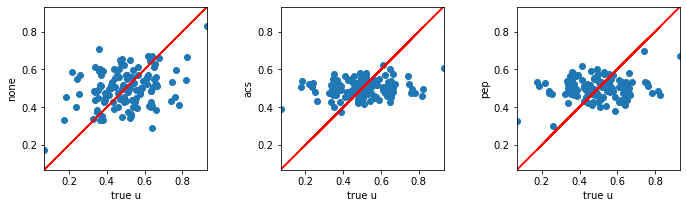

In [9]:
plt.rcParams['figure.figsize'] = [12, 3]
labels = models[:]
labels.insert(0, 'none')

fig = plt.figure()
iter = 0

for pivot_DGP in range(-1,0):
    
    ## Get the true u values
    u_true = res_dict['pDGP: ' + str(pivot_DGP) + '; pfit: -1'][4]
    CAR_df = pd.DataFrame(u_true[0,:,:], columns = models)
    
    for pivot_fit in range(-1,2):
        iter = iter + 1
        key = 'pDGP: ' + str(pivot_DGP) + '; pfit: ' + str(pivot_fit)    

        ## get the ensemble weights
        phi = res_dict[key][0][0]
        
        ## Get the u values from each run
        u = np.empty(shape=(phi.shape[0], 
                              len(models), 
                              phi.shape[2]), 
                       dtype='float64')
        for i in range(phi.shape[2]):
            u[:,:,i] = phi_to_u(phi.numpy()[:,:,i], pivot = pivot_fit)   
            
        CAR_df = pd.DataFrame(np.mean(u, axis = 2), columns = models)

        #plt.subplot(3, 4, iter)
        plt.subplot(1, 3, iter)

        x = np.ndarray.flatten(u_true[0,:,:].numpy())
        y = np.ndarray.flatten(CAR_df.values)
        plt.scatter(x, y)
        plt.xlabel("true u")
        plt.ylabel(labels[pivot_fit + 1])

        plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
        plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')

        ## obtain m (slope) and b(intercept) of linear regression line
        m, b = np.polyfit(x, y, 1)
        ## add linear regression line to scatterplot 
        #plt.plot(x, m*x+b, color = 'red')
        ## add y = x line
        plt.plot(x, x, color = 'red')


        from scipy.stats import pearsonr
        pearsonr(x,y)[0]
        
plt.show()

## Plotting the fitted vs true y predictions

In [ ]:
plt.rcParams['figure.figsize'] = [12, 3]
labels = models[:]
labels.insert(0, 'none')

fig = plt.figure()
iter = 0

for pivot_DGP in range(-1,0):
        
    ## Get the data
    data_pivot = res_dict['pDGP: ' + str(pivot_DGP) + '; pfit: -1'][5]
    
    ## Get the true u values
    u_true = res_dict['pDGP: ' + str(pivot_DGP) + '; pfit: -1'][4]
    CAR_df = pd.DataFrame(u_true[0,:,:], columns = models)
    y_exp = tf.reduce_sum(data_pivot[models].values*u_true, axis = 2)[0].numpy()
    
    for pivot_fit in range(-1,2):
        iter = iter + 1
        key = 'pDGP: ' + str(pivot_DGP) + '; pfit: ' + str(pivot_fit)    

        ## get the ensemble weights
        phi = res_dict[key][0][0]
        
        ## Get the u values from each run
        predictions = np.empty(shape=(phi.shape[0], 
                              phi.shape[2]), 
                       dtype='float64')
        for i in range(phi.shape[2]):
            u = phi_to_u(phi.numpy()[:,:,i], pivot = pivot_fit)   
            predictions[:,i] = tf.reduce_sum(data_pivot[models].values*u, axis = 1)
    
        y_pred = np.mean(predictions, axis = 1)
            
        #CAR_df = pd.DataFrame(np.mean(u, axis = 2), columns = models)

        #plt.subplot(3, 4, iter)
        plt.subplot(1, 3, iter)

        x = data_pivot['census']
        y = y_pred
        #y = y_pred.numpy()
        plt.scatter(x, y)
        plt.xlabel("true census values")
        plt.ylabel(labels[pivot_fit + 1])

        #obtain m (slope) and b(intercept) of linear regression line
        m, b = np.polyfit(x, y.astype('float64'), 1)

        plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
        plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        ax.set_xscale("log")
        ax.set_yscale("log")

        ## obtain m (slope) and b(intercept) of linear regression line
        m, b = np.polyfit(x, y, 1)
        ## add linear regression line to scatterplot 
        #plt.plot(x, m*x+b, color = 'red')
        ## add y = x line
        plt.plot(x, x, color = 'red')
        
plt.show()

## Plotting the chloroploth maps

In [ ]:
# Create the weights dict for plotting the outcomes

weights_dict = {
    "acs": CAR_ensemble_weights[:,0],
    "pep": CAR_ensemble_weights[:,1],
    "worldpop": CAR_ensemble_weights[:,2]
}

color_weights = make_color_norm(
    list(weights_dict.values())[1],   
    method="percentile")

In [ ]:
norm_weights_dict = {
    "acs": u[:,0],
    "pep": u[:,1],
    "worldpop": u[:,2]
}

color_norm_weights = make_color_norm(
    list(norm_weights_dict.values())[1],   
    method="percentile")

In [ ]:
import plotly
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
# df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
#                    dtype={"fips": str})
import matplotlib.colors as colors

import plotly.express as px

In [ ]:
for model_name in models:
    output = pd.DataFrame(np.column_stack([data_sub[["GEOID"]], weights_dict[model_name]]))
    output = output.set_axis(['GEOID', model_name], axis=1)
    output[model_name] = output[model_name].astype(float)
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #mapbox_style='white-bg',
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5#,
                           #labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

In [ ]:
# pd.concat([data_NY[["GEOID"]].reset_index(drop=True), pd.DataFrame( phi_true[0].numpy(), columns = models)], axis=1)
# pd.DataFrame( phi_true[0].numpy(), columns = models)

In [ ]:
full_phi = pd.concat([data_sub[["GEOID"]].reset_index(drop=True), 
                         pd.DataFrame(phi_true[0].numpy(), columns = models)], 
                        axis=1)

full_u = pd.concat([data_sub[["GEOID"]].reset_index(drop=True), 
                         pd.DataFrame(u_true[0].numpy(), columns = models)], 
                        axis=1)


#full_phi[['GEOID', 'acs']], full_u

In [ ]:
for model_name in models:
    output = full_phi[['GEOID', model_name]]
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #mapbox_style='white-bg',
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5#,
                           #labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()